Carly Raskin and Edwin Bosch

COMP 4432

Project 03

# **Experiment Objective**
---

Our object would be: to identify the type of pistacio based on the image. 

Citation Request:

1: SINGH D, TASPINAR YS, KURSUN R, CINAR I, KOKLU M, OZKAN IA, LEE H-N., (2022). Classification and Analysis of Pistachio Species with Pre-Trained Deep Learning Models, Electronics,11 (7), 981. https://doi.org/10.3390/electronics11070981. (Open Access)

DOI: https://doi.org/10.3390/electronics11070981

2: OZKAN IA., KOKLU M. and SARACOGLU R. (2021). Classification of Pistachio Species Using Improved K-NN Classifier. Progress in Nutrition, Vol. 23, N. 2. https://doi.org/10.23751/pn.v23i2.9686. (Open Access)

DOI: https://doi.org/10.23751/pn.v23i2.9686

https://www.muratkoklu.com/datasets/

New data set. Airplanes and cars. Advice from prof:

my usual approach is to take some small subset (say 10 images) and work on the loading and preprocessing one step at a time. start with a function that loads and decodes a single image, then create the code that loads multiple images and associates the labels, then experiment with data augmentation and any other preprocessing you need to do. the end goal is to get a set of functions that can reliably load or reload your dataset, associate your labels (in training), crop/resize, apply the augmentation if necessary, then return a tensor with the desired dimensions for your model (batch_size, height, width, channels)

# **Data Collection and Preprocessing**
---

Change to work on your drive

In [ ]:
from google.colab import drive
google_drive_root='Project03'
google_drive_mount_location = '/content/drive'
google_file_prefix=google_drive_mount_location + '/My Drive/Machine Learning/' + google_drive_root + '/'
drive.mount(google_drive_mount_location)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carly's version
"""
from google.colab import drive
google_drive_root='Project03'
google_drive_mount_location = '/content/drive'
google_file_prefix=google_drive_mount_location + '/My Drive/' + google_drive_root + '/'
drive.mount(google_drive_mount_location)
"""

"\nfrom google.colab import drive\ngoogle_drive_root='Project03'\ngoogle_drive_mount_location = '/content/drive'\ngoogle_file_prefix=google_drive_mount_location + '/My Drive/' + google_drive_root + '/'\ndrive.mount(google_drive_mount_location)\n"

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
from mlxtend.plotting import plot_decision_regions

In [ ]:
# declare directory prefixes for train and test datasets
data_dir_train = google_file_prefix+"images/_validate"
data_dir_test = google_file_prefix+"images/_test"


In [ ]:
# load data for the model
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                       labels="inferred",
                                                       label_mode="categorical")
test_ds = tf.keras.utils.image_dataset_from_directory(data_dir_test,
                                                      labels="inferred",
                                                      label_mode="categorical")

class_names = train_ds.class_names
class_names

Found 323 files belonging to 3 classes.
Found 12 files belonging to 3 classes.


['airplane', 'car', 'motorbike']

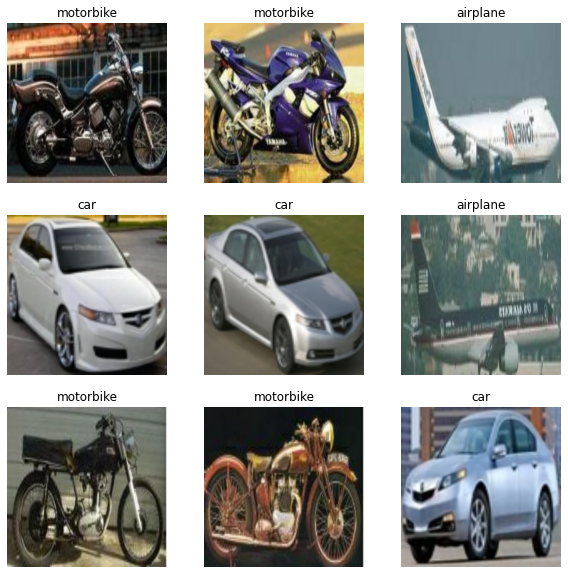

In [ ]:
def fixer(tensor):
  if tensor[0] == 1:
    return 0
  elif tensor[1] == 1:
    return 1
  else:
    return 2

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[fixer(labels[i])])
    plt.axis("off")


Here we create the functions that will later be used to build the estimator

In [ ]:
def train_input_fn():
  return tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                       labels="inferred",
                                                       label_mode="categorical")

def test_input_fn():
  return tf.keras.utils.image_dataset_from_directory(data_dir_test,
                                                       labels="inferred",
                                                       label_mode="categorical")

num_estimator_steps = 15

# **TensorFlow Model Creation**
---

### Explanation

We chose the two imput convolutional laayers because they provide a basic starting place for image analysis. We added two large hidden layers for better accuracy and found good results, thus decided to keep the model as is.

In [ ]:

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu", 
                                 input_shape=(256, 256, 3)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dense(
    units=1024, name='fc_2', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))

model.add(tf.keras.layers.Dense(3, activation="softmax", name='decoder_dense'))


In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 252, 32)      18464     
                                                                 
 pool_2 (MaxPooling2D)       (None, 126, 126, 32)      0         
                                                                 
 flatten_3 (Flatten)         (None, 508032)            0         
                                                                 
 fc_1 (Dense)                (None, 1024)              520225792 
                                                                 
 fc_2 (Dense)                (None, 1024)              1049600   
                                                                 
 dropout_3 (Dropout)         (None, 1024)             

# **TensorFlow Estimator Creation and Training**

---

The model has to be rerun after the fit in order for the estimator to work

In [ ]:
keras_estimator = tf.keras.estimator.model_to_estimator(keras_model=model)

In [ ]:
keras_estimator.train(input_fn=train_input_fn, steps=num_estimator_steps)
eval_result = keras_estimator.evaluate(input_fn=test_input_fn, steps=num_estimator_steps)
print('Eval result: {}'.format(eval_result))

Found 323 files belonging to 3 classes.
Found 12 files belonging to 3 classes.
Eval result: {'accuracy': 0.41666666, 'loss': 66.568214, 'global_step': 11}


# **TensorFlow Estimator Performance Evaluation and Visualization**
---

We can now fit the model since the estimator has been created

In [ ]:

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu", 
                                 input_shape=(256, 256, 3)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dense(
    units=1024, name='fc_2', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))

model.add(tf.keras.layers.Dense(3, activation="softmax", name='decoder_dense'))


In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 252, 252, 32)      18464     
                                                                 
 pool_2 (MaxPooling2D)       (None, 126, 126, 32)      0         
                                                                 
 flatten_4 (Flatten)         (None, 508032)            0         
                                                                 
 fc_1 (Dense)                (None, 1024)              520225792 
                                                                 
 fc_2 (Dense)                (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)             

In [ ]:
result = model.fit(train_ds, epochs = 5, steps_per_epoch=len(train_ds))

Epoch 1/5
11/11 [==============================] - 90s 8s/step - loss: 7236.8608 - accuracy: 0.3158
Epoch 2/5
11/11 [==============================] - 83s 7s/step - loss: 2.4434 - accuracy: 0.7337
Epoch 3/5
11/11 [==============================] - 85s 8s/step - loss: 0.5237 - accuracy: 0.8978
Epoch 4/5
11/11 [==============================] - 83s 8s/step - loss: 0.1201 - accuracy: 0.9752
Epoch 5/5
11/11 [==============================] - 84s 8s/step - loss: 0.0265 - accuracy: 0.9876


In [ ]:
def item_prediction(new_image):
  test_image = tf.keras.preprocessing.image.load_img(new_image, target_size = (256,256))
  plt.axis("off")
  plt.imshow(test_image)
  plt.show()
 
  test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255
  test_image = np.expand_dims(test_image, axis=0)

  predicted_array = model.predict(test_image)
  predicted_value = class_names[np.argmax(predicted_array)]
  predicted_accuracy = round(np.max(predicted_array) * 100, 2)

  print("Your picture is ", predicted_value, " with ", predicted_accuracy, " % accuracy")


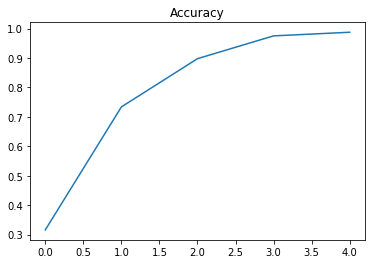

In [ ]:
plt.title("Accuracy")
plt.plot(result.history["accuracy"])
plt.show()

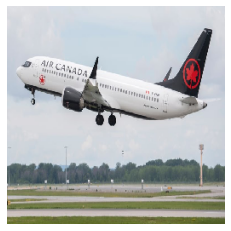

Your picture is  airplane  with  37.04  % accuracy


In [ ]:
item_prediction(google_file_prefix+"airplane_.jpg")

# Conclusion

Our model did indeed perform well once we were able to get it working. 